In [1]:
import numpy as np
import pandas as pd
import pdb
from ipynb.fs.full.Game import *
from random import randrange

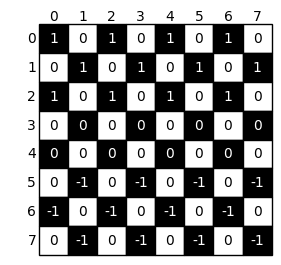

In [2]:
board_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
state = [board_1, -1]
visualize(state)

In [3]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[4] = 1
bb[6] = 1
bb[9] = -1
bb[10] = -1
bb[17] = -1
bb[18] = -1

fix_dict(can_eat([bb, 1, (21,25)])[1], bb)

[[(4, 9), (13, 17)],
 [(4, 9), (13, 18)],
 [(6, 10), (13, 17)],
 [(6, 10), (13, 18)]]

In [4]:
action_space = [(0,4),#0
 (1,4),#1
 (1,5),#2
 (2,5),#3
 (2,6),#4
 (3,6),#5
 (3,7),#6
 (4,0),#7
 (4,1),#8
 (4,8),#9
 (4,9),#10
 (5,1),#11
 (5,2),#12
 (5,9),#13
 (5,10),#14
 (6,2),#15
 (6,3),#16
 (6,10),#17
 (6,11),#18
 (7,3),#19
 (7,11),#20
 (8,4),#21
 (8,12),#22
 (9,4),#23
 (9,5),#24
 (9,12),#25
 (9,13),#26
 (10,5),#27
 (10,6),#28
 (10,13),#29
 (10,14),#30
 (11,6),#31
 (11,7),#32
 (11,14),#33
 (11,15),#34
 (12,8),#35
 (12,9),#36
 (12,16),#37
 (12,17),#38
 (13,9),#39
 (13,10),#40
 (13,17),#41
 (13,18),#42
 (14,10),#43
 (14,11),#44
 (14,18),#45
 (14,19),#46
 (15,11),#47
 (15,19),#48
 (16, 12),#49
 (16, 20),#50
 (17, 12),#51
 (17, 13),#52
 (17, 20),#53
 (17, 21),#54
 (18, 13),#55
 (18, 14),#56
 (18, 21),#57
 (18, 22),#58
 (19, 14),#59
 (19, 15),#60
 (19, 22),#61
 (19, 23),#62
 (20, 16),#63
 (20, 17),#64
 (20, 24),#65
 (20, 25),#66
 (21, 17),#67
 (21, 18),#68
 (21, 25),#69
 (21, 26),#70
 (22, 18),#71
 (22, 19),#72
 (22, 26),#73
 (22, 27),#74
 (23, 19),#75
 (23, 27),#76
 (24, 20),#77
 (24, 28),#78
 (25, 20),#79
 (25, 21),#80
 (25, 28),#81
 (25, 29),#82
 (26, 21),#83
 (26, 22),#84
 (26, 29),#85
 (26, 30),#86
 (27, 22),#87
 (27, 23),#88
 (27, 30),#89
 (27, 31),#90
 (28, 24),#91
 (28, 25),#92
 (29, 25),#93
 (29, 26),#94
 (30, 26),#95
 (30, 27),#96
 (31, 27)]#97

# Q table

## init

In [5]:
white_board = [board_1]

In [6]:
white_board.index(board_1)

0

In [7]:
white_state_dict = {}
white_state_dict[white_board.index(board_1)] = board_1

In [8]:
Q_white = pd.DataFrame(data = 0, index= white_state_dict.keys(), columns=action_space)

In [9]:
Q_white.head()

,"(0, 4)","(1, 4)","(1, 5)","(2, 5)","(2, 6)","(3, 6)","(3, 7)","(4, 0)","(4, 1)","(4, 8)",...,"(27, 23)","(27, 30)","(27, 31)","(28, 24)","(28, 25)","(29, 25)","(29, 26)","(30, 26)","(30, 27)","(31, 27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
if bb not in white_state_dict.items():
    white_state_dict[max(white_state_dict.keys()) +1] = bb

In [11]:
white_state_dict

{0: array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,
         0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 1: array([ 0,  0,  0,  0,  1,  0,  1,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])}

In [12]:
Q_white.head()

,"(0, 4)","(1, 4)","(1, 5)","(2, 5)","(2, 6)","(3, 6)","(3, 7)","(4, 0)","(4, 1)","(4, 8)",...,"(27, 23)","(27, 30)","(27, 31)","(28, 24)","(28, 25)","(29, 25)","(29, 26)","(30, 26)","(30, 27)","(31, 27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
Q_white.loc[2] = 432

In [14]:
Q_white

,"(0, 4)","(1, 4)","(1, 5)","(2, 5)","(2, 6)","(3, 6)","(3, 7)","(4, 0)","(4, 1)","(4, 8)",...,"(27, 23)","(27, 30)","(27, 31)","(28, 24)","(28, 25)","(29, 25)","(29, 26)","(30, 26)","(30, 27)","(31, 27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,432,432,432,432,432,432,432,432,432,432,...,432,432,432,432,432,432,432,432,432,432


## game over

In [15]:
b = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

b[0] = 1

In [16]:
def game_over(action_space, full_state):
    new_full_state = full_state.copy()
    res = []
    for move in action_space:
        new_full_state[2] = move
        res.append(referee(action_space, new_full_state)[0])
    #pdb.set_trace()
    return all(res)
    

In [17]:
game_over(action_space, [b, -1, (0,4)])

False

In [18]:
Q_white.loc[[0],[(0,4)]]

,"(0, 4)"
0,0


## history

In [19]:
hist_white = {}


## learning 

In [20]:
def learning(state,new_state,action,lr,reward,gamma):#state and action are int taken from dictionaries
    Q[state,action] = Q[state,action] + lr * (reward + gamma * np.max(Q[new_state,:]) - Q[state,action])

In [21]:
white_board.index(board_1)

0

In [22]:
Q_white.eq(max(Q_white.loc[white_board.index(board_1)]))

,"(0, 4)","(1, 4)","(1, 5)","(2, 5)","(2, 6)","(3, 6)","(3, 7)","(4, 0)","(4, 1)","(4, 8)",...,"(27, 23)","(27, 30)","(27, 31)","(28, 24)","(28, 25)","(29, 25)","(29, 26)","(30, 26)","(30, 27)","(31, 27)"
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
Q_white.loc[white_board.index(board_1), Q_white.eq(max(Q_white.loc[white_board.index(board_1)])).any()]

(0, 4)      0
(1, 4)      0
(1, 5)      0
(2, 5)      0
(2, 6)      0
           ..
(29, 25)    0
(29, 26)    0
(30, 26)    0
(30, 27)    0
(31, 27)    0
Name: 0, Length: 98, dtype: int64

In [24]:
len(list(Q_white.loc[white_board.index(board_1), Q_white.loc[white_board.index(board_1)] == max(Q_white.loc[white_board.index(board_1)])].index))

98

In [25]:
Q_white.loc[white_board.index(board_1)] == 0

(0, 4)      True
(1, 4)      True
(1, 5)      True
(2, 5)      True
(2, 6)      True
            ... 
(29, 25)    True
(29, 26)    True
(30, 26)    True
(30, 27)    True
(31, 27)    True
Name: 0, Length: 98, dtype: bool

## Training

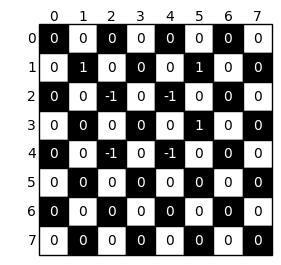

In [26]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[4] = 1
bb[6] = 1
bb[9] = -1
bb[10] = -1
bb[14] = 1
bb[17] = -1
bb[18] = -1
visualize([bb, (0,4)])

In [7]:
white_state_dict = {}
white_state_dict[white_board.index(board_1)] = board_1

In [8]:
Q_white = pd.DataFrame(data = 0, index= white_state_dict.keys(), columns=action_space)

In [115]:
def training_white(initial_board, agent = -1, white_boards = np.array([board_1]), white_hist = [], 
                   white_mult_caps_dict={}):
    '''Problem with this function is that it relies on Q_white which relies on white_state_dict both defined outside
    the function. In addition there are many table/list that are important to the training purpose. NEED to 
    understand what it will return!
    '''
    
    #if agent == -1:
    if sum([(initial_board == board).all() for board in white_boards]) == 0:
        #initialise board in Q table
        white_boards = np.append(white_boards, [initial_board], axis=0)
        #add board index as row  in Q
        ind_board = white_boards.shape[0] -1 
        Q_white.loc[ind_board] = 0

    #case where board was already seen
    else: 
        #first create list where first true is the idx of the board
        ind_board = [idx for idx, bb in enumerate([(initial_board == b).all() for b in white_boards]) if bb][0]

    is_legal = False
    while is_legal == False:
        #choose move by selecting the max col in row representing current board
        moves = list(Q_white.loc[ind_board, Q_white.loc[ind_board] == max(Q_white.loc[ind_board])].index)
        #if more than one optimal move
        if len(moves)>1: 
            #random choice 
            my_move = moves[randrange(len(moves))]
        else:
            my_move = moves

        full_state = [initial_board, agent, my_move]
        is_legal, caps = referee(action_space, full_state)
        if not is_legal:
            #set move to -100 (i.e. illegal)
            Q_white.loc[[ind_board], [my_move]] += -100

    #NOW my_move is legal
    #if you can eat
    if caps != 0:
        # RARE: if there are multiple double caps
        if len(caps[0]) > 1 and len(caps) > 1:
            #add board to nested dict of situation with multiple caps for white
            if ind_board not in white_mult_caps_dict.keys():
                white_mult_caps_dict[ind_board] = {}
                for mov in caps:
                    white_mult_caps_dict[ind_board][str(mov)] = 0
            my_move = max(white_mult_caps_dict[ind_board])
            #pdb.set_trace()
            my_move = [mov for mov in caps if str(mov) == my_move][0]
        #case when there's one multiple cap
        elif len(caps[0]) > 1:
            my_move = caps[0]
    #update board after move
    #first rare case where there are multiple caps
    if type(my_move) == list:
        for cap in my_move:
            initial_board = nextState([initial_board, agent, cap], cap)
    #all other cases (single cap or simple move)
    else:
        initial_board = nextState([initial_board, agent, my_move], my_move)
    visualize([initial_board, agent])
    #add to history of moves in this game for white
    white_hist.append(my_move)

        
        

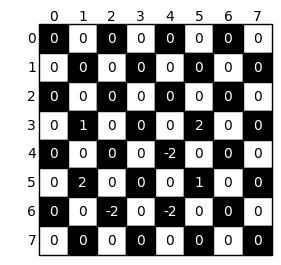

In [132]:
bb = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,])

bb[26] = -2
bb[25] = -2
bb[20] = 2
bb[22] = 1
bb[14] = 2
bb[12] = 1
bb[18] = -2
visualize([bb, (0,4)])

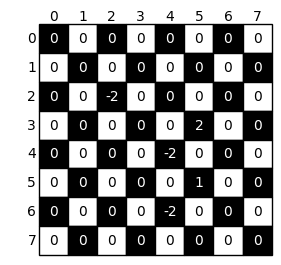

In [133]:
training_white(bb, -1)

In [584]:
[i for i, j in enumerate([(bb == x).all() for x in ll]) if j][0]

1

In [30]:
sum([(bb == x).all() for x in ll])

0

In [29]:
ll = np.array([board_1])
#ll.index(bb)

In [602]:
ll

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [573]:
ll.shape

(3, 32)

In [572]:
ll = np.append(ll, [bb], axis=0)

In [575]:
(board == ll[0]).all()

True

In [576]:
ll

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  1,  0,  1,  0,  0, -1, -1,  0,  0,  0,  1,  0,
         0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  1,  0,  0, -1, -1,  0,  0,  0,  1,  0,
         0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [559]:
np.where(ll == bb)

(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([ 4,  6, 12, 13, 15, 16, 19,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
        10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31]))

In [525]:
if not any([(bb == x).all() for x in [board_1, board]]):
    print('new board')

new board


In [226]:
Q_white

,"(0, 4)","(1, 4)","(1, 5)","(2, 5)","(2, 6)","(3, 6)","(3, 7)","(4, 0)","(4, 1)","(4, 8)",...,"(27, 23)","(27, 30)","(27, 31)","(28, 24)","(28, 25)","(29, 25)","(29, 26)","(30, 26)","(30, 27)","(31, 27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,432,432,432,432,432,432,432,432,432,432,...,432,432,432,432,432,432,432,432,432,432


In [452]:
Q_white.loc[0, Q_white.loc[0,: ] == 0]

(20, 16)    0
(20, 17)    0
(21, 17)    0
(21, 18)    0
(22, 18)    0
(22, 19)    0
(23, 19)    0
Name: 0, dtype: int64

In [454]:
training(board_1, -1)

(22, 19)


In [294]:
Q_white.transpose()[Q_white.transpose()[0] == -100]

,0,1,2
"(12, 8)",-100,0,432
"(15, 11)",-100,0,432
"(26, 29)",-100,0,432


In [244]:
len(list(Q_white.loc[white_board.index(board_1), Q_white.loc[white_board.index(board_1)] == max(Q_white.loc[white_board.index(board_1)])].index))

97

In [233]:
min(Q_white.loc[0])

-100

# Luigi

In [22]:
numbers = np.arange(1,99,1)

In [23]:
action_dict = dict(zip(numbers,action_space))

In [24]:
action_dict

{1: (0, 4),
 2: (1, 4),
 3: (1, 5),
 4: (2, 5),
 5: (2, 6),
 6: (3, 6),
 7: (3, 7),
 8: (4, 0),
 9: (4, 1),
 10: (4, 8),
 11: (4, 9),
 12: (5, 1),
 13: (5, 2),
 14: (5, 9),
 15: (5, 10),
 16: (6, 2),
 17: (6, 3),
 18: (6, 10),
 19: (6, 11),
 20: (7, 3),
 21: (7, 11),
 22: (8, 4),
 23: (8, 12),
 24: (9, 4),
 25: (9, 5),
 26: (9, 12),
 27: (9, 13),
 28: (10, 5),
 29: (10, 6),
 30: (10, 13),
 31: (10, 14),
 32: (11, 6),
 33: (11, 7),
 34: (11, 14),
 35: (11, 15),
 36: (12, 8),
 37: (12, 9),
 38: (12, 16),
 39: (12, 17),
 40: (13, 9),
 41: (13, 10),
 42: (13, 17),
 43: (13, 18),
 44: (14, 10),
 45: (14, 11),
 46: (14, 18),
 47: (14, 19),
 48: (15, 11),
 49: (15, 19),
 50: (16, 12),
 51: (16, 20),
 52: (17, 12),
 53: (17, 13),
 54: (17, 20),
 55: (17, 21),
 56: (18, 13),
 57: (18, 14),
 58: (18, 21),
 59: (18, 22),
 60: (19, 14),
 61: (19, 15),
 62: (19, 22),
 63: (19, 23),
 64: (20, 16),
 65: (20, 17),
 66: (20, 24),
 67: (20, 25),
 68: (21, 17),
 69: (21, 18),
 70: (21, 25),
 71: (21, 26)

In [25]:
initial_state = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]

In [26]:
zeros = np.zeros((1,98))

In [27]:
Q = np.zeros((1,98))

In [28]:
Q

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [29]:
rows = {'1' : [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]}

In [30]:
state = (1,1,1,1,1,2,2,3,5,11,2,3,4,5,2,1,4)

In [31]:
def learning(state,new_state,action,lr,reward,gamma):#state and action are int taken from dictionaries
    Q[state,action] = Q[state,action] + lr * (reward + gamma * np.max(Q[new_state,:]) - Q[state,action])

In [32]:
def game_over(board):
    negative_counter = 0
    positive_counter = 0
    #CHANGE
    for x in action_space:
        if referee(x)[0] == True:
            return False
    #PROB delete
    for x in board:
        if x < 0:
            negative_counter += 1
        elif x > 0:
            positive_counter += 1
    if negative_counter > 0 and positive_counter > 0:
        return False
    return True
    

In [33]:
def determine_reward():
    if referee(action_space,full_state)[0] == False:
        return -1
    elif game_over() == True:
        return 1 #don't understand why
    else:
        return 0

In [34]:
def append_dict(state,Q):
    if state not in rows.values():
        rows[f'{len(rows)+1}'] = state
        Q = np.append(Q,zeros,axis = 0)
        return Q
    return Q

In [35]:
Q = append_dict([1,2,3,4,5,6,7,8,9],Q)

In [36]:
rows

{'1': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '2': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [37]:
Q.shape

(2, 98)

In [38]:
rows

{'1': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '2': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [39]:
def get_temporal_difference(state_index,move_index,reward,gamma):
    max_action = np.argmax(Q[state_index])
    max_Q = Q[state_index][max_action]
    current_Q = Q[state_index][move_index]
    return reward + (gamma * (max_Q - current_Q))

# training

In [40]:
lr = 1
gamma = 0.8
reward = 0

In [41]:
full_state = [[0,1,1,1,1],1,(4,10)]

In [42]:
state = full_state[0]

In [43]:
def epsilon_greed(current_board,epsilon):
    state_number = 0
    for number,board_state in rows.items():
        if board == current_board:
            state_number = number
        else:
            append_dict(full_state[0])
    if np.random.random() < epsilon:
        return np.argmax(Q[state_number])
    else:
        return np.random.randint(98)

In [44]:
full_state = []

In [45]:
np.argmax(Q[1])

0

In [46]:
Q[1][19] = 23

In [47]:
def get_move(index):
    return action_space[index]

In [157]:
for episode in range(1000):
    board = full_state[0]
    state_index = 0
    for number,board_state in rows.items():
        if board == full_state[0]:
            state_index = number
        else:
            append_dict(full_state[0])
            for number,board_state in rows.items():
                if board == full_state[0]:
                    state_index = number
            
    while game_over(board) == False:
        move_index = epsilon_greed(full_state,epsilon)
        move = get_move(move_index)
        legal_boolean = referee(full_state) #referee the move
        if legal_boolean == False:
            reward = -1
            temporal_difference = get_temporal_difference
            Q[state_index][move_index] = Q[state_index][move_index] + lr * temporal_difference
            continue 
        reward = get_reward()
        nextState()
        Q[state_index][move_index] = Q[state_index][move_index] + lr * temporal_difference

NameError: name 'rows' is not defined